In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os, csv
import pandas as pd
import scipy.optimize as sp
import time

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

%run /home/jebediah/Ising_RSRG/aux_funcs.py
%run /home/jebediah/Ising_RSRG/RSRG_bdry_class.py
%run /home/jebediah/Ising_RSRG/bdry_aux_funcs.py

In [2]:
log_file = pd.read_csv("bdry_log_file.csv")
ts_list = log_file['ts'].tolist()
log_file

,L,steps,w_blk,w_bdry,w_mixed,n_runs,ts
0,50,2480,2.25,0.1,2.6,560,1681168497
1,50,2480,2.20,0.1,2.6,560,1681168640
2,50,2480,2.30,0.1,2.6,560,1681170503
3,50,2480,2.35,0.1,2.6,560,1681170681
4,50,2480,2.40,0.1,2.6,560,1681172524
5,50,2480,2.45,0.1,2.6,560,1681172760
6,50,2480,2.50,0.1,2.6,560,1681174554
7,50,2480,2.55,0.1,2.6,560,1681174828
8,50,2480,2.60,0.1,2.6,560,1681176684
9,50,2480,2.65,0.1,2.6,560,1681176862


In [3]:
def generate_corr_matrix(reverse_dict, L):
    vect = np.zeros(shape=(L*L, L*L), dtype=bool)
    for key in reverse_dict:
        if reverse_dict[key] is None: continue
        vect[key,reverse_dict[key]] = True
    return np.einsum('ab,ac->bc', vect, vect)

def generate_corr_matrix_alt(clust_dict, L):
    corr_mat_alt = np.zeros(shape=(L*L, L*L), dtype=bool)
    for i in range(L*L):
        for j in range(i, L*L):
            corr_mat_alt[i,j] = (clust_dict[i]==clust_dict[j])
    corr_mat_alt = corr_mat_alt.T + corr_mat_alt 
    return corr_mat_alt

def generate_corr_matrix_alt2(clust_dict, reverse_dict, L):
    #Fastest
    corr_mat = np.zeros(shape=(L*L, L*L), dtype=bool)
    for i in range(L*L):
        corr_mat[i, reverse_dict[clust_dict[i]]] = True
    return corr_mat

def power_law(x, scale, power):
    return 1/(1+x*scale)**power

In [ ]:
L = 100


fixed_length_slice = log_file[lambda df: (df['L'] == L)]
ts_list = fixed_length_slice['ts'].tolist()
w_vals = fixed_length_slice['w_blk'].tolist()
n_runs_list = fixed_length_slice['n_runs'].tolist()

mean_corr_mat_list = []

for index, ts in enumerate(ts_list):

    with open("IsingB_2D_clusters_"+str(ts)+".pkl", "rb") as fp:   
        clust_list_final = pickle.load(fp)


    clust_dict_list, reverse_dict_list = [], []

    for core_pair in clust_list_final:
        clust_list_temp = core_pair[0]
        reverse_list_temp = core_pair[1]
        clust_dict_list+=clust_list_temp
        reverse_dict_list+=reverse_list_temp

    mean_corr_mat = np.zeros(shape=(L*L,L*L))
    for instance in range(len(reverse_dict_list)):
        mean_corr_mat += generate_corr_matrix_alt2(clust_dict_list[instance], reverse_dict_list[instance], L)
    mean_corr_mat = mean_corr_mat/n_runs_list[index]

    mean_corr_mat_list.append(mean_corr_mat)

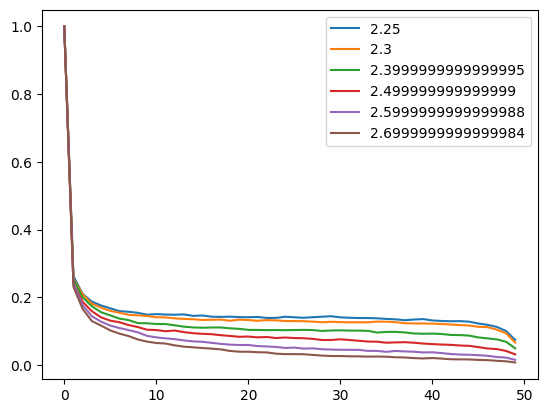

In [34]:
for index, w in enumerate(w_vals):
    if not index%2==0: continue
    mean_corr_mat = mean_corr_mat_list[index]
    y_vals = np.arange(L)
    corr_function = np.zeros(shape=(L))

    for y in range(L):
        for x in range(L):
            corr_function[y] += mean_corr_mat[index_map(0,x,L), index_map(y,x,L)]

    plt.plot(y_vals, corr_function/L, label=str(w))

    #popt, pcov = curve_fit(power_law, y_vals,corr_function/L)

    #plt.plot(y_vals, power_law(y_vals, *popt))

plt.legend()
#plt.xlim(0, 20)
#print(*popt)

In [11]:
ts = 1681168497

with open("IsingB_2D_clusters_"+str(ts)+".pkl", "rb") as fp:   
        clust_list_final = pickle.load(fp)


clust_dict_list, reverse_dict_list = [], []

for core_pair in clust_list_final:
    clust_list_temp = core_pair[0]
    reverse_list_temp = core_pair[1]
    clust_dict_list+=clust_list_temp
    reverse_dict_list+=reverse_list_temp

t0 = time.time()
corr_mat_alt2 = generate_corr_matrix_alt2(clust_dict_list[0], reverse_dict_list[0], 50)
print(time.time()-t0)

0.08069372177124023
